In [64]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML
#from matplotlib import rc

In [65]:
# -----------------------------------------------------------------------------
# Floor plan options for the assignment
# -----------------------------------------------------------------------------
class particle:
  def __init__(self, x, y, goal = 0):
    self.x = x
    self.y = y
    self.velocity = [0,0]
    self.speed = 0
    self.u_direction = [0,0]
    self.goal = goal
  def set_position(self, x, y):
    self.x = x
    self.y = y
  def set_velocity(self, dx, dy):
    self.velocity = [dx, dy]
    magnitude = np.linalg.norm(np.array([dx,dy]))
    if magnitude == 0:
        self.speed = 0
        self.u_direction = [0,0]
    else:
        self.speed = magnitude
        self.u_direction = [dx/magnitude, dy/magnitude]
  def get_position(self):
    return [self.x, self.y]
  def get_velocity(self):
    return self.velocity
  def get_unit_vector(self):
    return self.u_direction
  def get_speed(self):
    return self.speed
  def get_goal(self):
    return self.goal

import numpy as np

def load_floor_plan(name="baseline"):
    """
    Load a predefined floor plan.

    Available options:
      - "baseline"  : corridor + corner (recommended default)
      - "zigzag"    : narrow zig-zag corridor (oscillation test)
      - "deadend"   : dead-end with escape (local minimum trap)
      - "symmetric" : symmetric obstacle trap (pathological case)

    Returns:
      walls : list of (a, b) line segments
      start : np.array shape (2,)
      goal  : np.array shape (2,)
    """

    if name == "baseline":
        walls = [
            # Outer boundary
            ([-5, -5], [ 5, -5]),
            ([ 5, -5], [ 5,  5]),
            ([ 5,  5], [-5,  5]),
            ([-5,  5], [-5, -5]),

            # Interior corridor
            ([-1, -5], [-1,  2]),
            ([-1,  2], [ 3,  2]),
            ([ 3,  2], [ 3, -2]),
        ]
        particles = [particle(-4.0, -4.0, 0),
                     particle( 0.0,  0.0, 0),
                     particle(-2.0, -4.0, 0),
                     particle( 4.0, -4.0, 0),
                     particle( 0.0, -1.0, 0),
                     particle(-2.0, -2.0, 0)]
        goal  = [[ 4.0,  4.0]]

    elif name == "zigzag":
        walls = [
            # Outer boundary
            ([-6, -4], [ 6, -4]),
            ([ 6, -4], [ 6,  4]),
            ([ 6,  4], [-6,  4]),
            ([-6,  4], [-6, -4]),

            # Zig-zag corridor
            ([-4, -3], [-1, -3]),
            ([-1, -3], [-1,  0]),
            ([-1,  0], [ 2,  0]),
            ([ 2,  0], [ 2,  3]),
            ([ 2,  3], [ 5,  3]),
        ]
        particles = [particle(-5.0, -3.5),
                     particle(-4.0, -3.5),
                     particle(-3.0, -3.0),
                     particle( 0.0, -1.0),
                     particle( 0.0, -2.5),
                     particle( 4.0, -3.5),]
        goal  = [[ 5.0,  3.5]]

    elif name == "deadend":
        walls = [
            # Outer boundary
            ([-6, -6], [ 6, -6]),
            ([ 6, -6], [ 6,  6]),
            ([ 6,  6], [-6,  6]),
            ([-6,  6], [-6, -6]),

            # Dead-end chamber
            ([-2, -6], [-2,  2]),
            ([-2,  2], [ 2,  2]),
            ([ 2,  2], [ 2, -2]),
            ([ 2, -2], [-4, -2]),
            ([-4, -2], [-4,  4]),
        ]
        particles = [particle( 0.0, -5.0, 0),
                     particle( 0.0,  1.0, 1),
                     particle(-1.0, -1.0, 1),
                     particle( 0.0,  1.0, 1),
                     particle(-5.0,  0.0, 2),
                     particle(-2.5, -5.5, 2)]
        goal  = [[ 5.0,  5.0],
                 [ 0.0,  0.0],
                 [-4.0, -4.0]]

    elif name == "symmetric":
        walls = [
            # Outer boundary
            ([-6, -6], [ 6, -6]),
            ([ 6, -6], [ 6,  6]),
            ([ 6,  6], [-6,  6]),
            ([-6,  6], [-6, -6]),

            # Symmetric obstacles
            ([-2, -2], [-2,  2]),
            ([ 2, -2], [ 2,  2]),
            ([-2,  2], [ 2,  2]),
        ]
        particles = [particle(0.0, -5.0)]
        goal  = [[ 0.0,  5.0]]

    else:
        raise ValueError(f"Unknown floor plan: {name}")

    # Convert to NumPy arrays
    walls = [(np.array(a, dtype=float), np.array(b, dtype=float)) for a, b in walls]

    return walls, particles, goal

In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Global Variables
# -------------------------------
Wall_R = 1
Particle_R = 5
gradient_step = 0.3
wall_cost_factor = 3
particle_direction_bias = 10

def point_to_point(A, B):
  return np.linalg.norm(np.array(B) - np.array(A))

# -------------------------------
# Geometry: distance to segment
# -------------------------------
def point_to_segment_distance_dot(x, a, b):
  v = b - a
  w = x - a
  vv = np.dot(v, v)

  if vv == 0.0:
      return np.linalg.norm(x - a)

  t = np.dot(w, v) / vv
  t = np.clip(t, 0.0, 1.0)
  q = a + t * v
  return np.linalg.norm(x - q)

def point_to_segment_distance_vectorize(x, a, b):
  v = b - a
  w = x - a
  vv = np.dot(v, v)

  if vv == 0.0:
      return np.linalg.norm(x - a)

  t = np.dot(w, v) / vv
  t = np.clip(t, 0.0, 1.0)
  q = a + t * v
  return max(abs(x[0]-q[0]),abs(x[1]-q[1]))

def select_point_to_segment_distance(name):
  if name == "dot":
      return point_to_segment_distance_dot
  if name == "vectorize":
      return point_to_segment_distance_vectorize
  raise ValueError(f"Unknown distance function: {name}")

#-------------------------------
# Selecting segment distance function
#-------------------------------
pts_distance= "vectorize"
point_to_segment_distance = select_point_to_segment_distance(pts_distance)

def nearest_wall_distance(X, Walls):
  min_d = 1000
  for a, b in Walls:
      d = point_to_segment_distance(X, a, b)
      if d < min_d:
          min_d = d
  return min_d - 0.05

# -------------------------------
# Wall penalty functions
# -------------------------------

#quadratic band
def wall_penalty_quad(x, a, b, R):
  d = point_to_segment_distance(x, a, b)
  if d <= R:
      return (R - d)**2
  else:
      return 0.0

# natural_log band
def wall_penalty_LN(x, a, b, R):
  d = point_to_segment_distance(x, a, b)
  if d <= R:
      if d < 0.01*R:
        return 5
      return math.log(R/d)
  else:
      return 0.0

def wall_penalty_linear(x, a, b, R):
  d = point_to_segment_distance(x, a, b)
  if d <= R:
      return R - d
  else:
      return 0.0

def wall_penalty_quartic(x, a, b, R):
  d = point_to_segment_distance(x, a, b)
  if d <= R:
      return (R - d)**4
  else:
      return 0.0

#-------------------------------
# Selecting wall penalty function
#-------------------------------
def select_wall_penalty(name):
  if name == "Quad":
      return wall_penalty_quad
  if name == "Quartic":
      return wall_penalty_quartic
  if name == "LN":
      return wall_penalty_LN
  if name == "Linear":
      return wall_penalty_linear
  raise ValueError(f"Unknown wall penalty: {name}")

wall_penalty_function = "LN"
wall_penalty= select_wall_penalty(wall_penalty_function)

#--------------------------------
# social forces
#--------------------------------
def particle_penatlty_quadratic(X, Y, R):
  d = point_to_point(X, Y)
  if d <= R:
      return (R - d)**2 / 2
  else:
      return 0.0


def select_particle_penalty(name):
  if name == "Quad":
      return particle_penatlty_quadratic

  raise ValueError(f"Unknown wall penalty: {name}")

particle_pentalty_func = "Quad"
particle_penatlty = select_particle_penalty(particle_pentalty_func)

def particle_penalty_anisotropic(curr_particle, Y, R):
  global particle_direction_bias
  X = curr_particle.get_position()
  V = curr_particle.get_unit_vector()

  diff = np.array(Y) - np.array(X)
  d = np.linalg.norm(diff)

  u_diff = np.array([0,0])
  if d != 0:
    u_diff = diff / d
  V_XY = np.dot(V, u_diff)

  base_penalty = particle_penatlty(X, Y, R)
  # C(i,j) = ( 1 + bias * max(0, V * XY)) * particle_penatlty(X, Y)
  return base_penalty * (1 + particle_direction_bias * max(0, V_XY))

# -------------------------------
# Cost function
# -------------------------------
def total_cost_function(X, G, Walls, Particles, pi, anisotropic):
  # C(x) = C_goal(x) + SUM_i(wi C_wall,i(x)) + SUM_i(wi C_particle,i(x))
  global Wall_R, Particle_R, wall_cost_factor

  wall_penalty_list = []
  weights = []
  #calcualte wall penalties
  for a,b in Walls:
    penalty = wall_penalty(X, a, b, Wall_R)
    if penalty > 0:
      wall_to_goal = min(point_to_segment_distance_dot(G, a, b), 1)
      weights.append(wall_to_goal)
      wall_penalty_list.append(penalty)
  wall_cnt = len(wall_penalty_list)
  if wall_cnt == 0:
    wall_cnt = 1

  #calcualte weighted wall cost
  total_wall_cost = 0
  for index, penalty in enumerate(wall_penalty_list):
    # weighted% * penalty => 1/wallcnt * penalty
    total_wall_cost += penalty * weights[index]
  total_wall_cost * wall_cost_factor/wall_cnt

  total_part_cost = 0
  for i,particle in enumerate(Particles):
    if i ==pi:
      continue

    if anisotropic:
      total_part_cost += particle_penalty_anisotropic(Particles[pi], particle.get_position(), Particle_R)
    else:
      total_part_cost += particle_penatlty(X, particle.get_position(), Particle_R)

  return  point_to_point(X, G) + total_wall_cost + total_part_cost

# ------------------------------
# Gradient functions
# ------------------------------

#gradient_avg
def cost_gradient_avg(pi, G, Walls, Particles, anisotropic):
  global gradient_step
  an = anisotropic
  X = Particles[pi].get_position()
  h = min (gradient_step, nearest_wall_distance(X, Walls))
  if h < 0.1:
    h = 0.1
  a, b = X
  base_vel = Particles[pi].get_velocity()
  Particles[pi].set_velocity(h,0)
  aph = total_cost_function([a + h, b], G, Walls, Particles, pi, an)
  Particles[pi].set_velocity(-h,0)
  amh = total_cost_function([a - h, b], G, Walls, Particles, pi, an)
  Particles[pi].set_velocity(0,h)
  bph = total_cost_function([a, b + h], G, Walls, Particles, pi, an)
  Particles[pi].set_velocity(0,-h)
  bmh = total_cost_function([a, b - h], G, Walls, Particles, pi, an)
  Particles[pi].set_velocity(base_vel[0],base_vel[1])
  da = (aph - amh) / (2 * h)
  db = (bph - bmh) / (2 * h)
  return [da, db]

#gradient_avg
def cost_gradient_simple(pi, G, Walls, Particles, anisotropic):
  global gradient_step
  an = anisotropic
  X = Particles[pi].get_position()
  h = min (gradient_step, nearest_wall_distance(X, Walls))
  if h ==0:
    h = 0.05
  a, b = X
  current_cost = total_cost_function(X, G, Walls, Particles, pi, an)
  current_velocity = Particles[pi].get_velocity()
  Particles[pi].set_velocity(h,0)
  ah = total_cost_function([a + h, b], G, Walls, Particles, pi, an)
  Particles[pi].set_velocity(0,h)
  bh = total_cost_function([a, b + h], G, Walls, Particles, pi, an)
  Particles[pi].set_velocity(current_velocity[0],current_velocity[1])
  da = (ah - current_cost) / h
  db = (bh - current_cost) / h
  return [da, db]

#-------------------------------
# Selecting gradient function
#-------------------------------
def select_gradient_function(name):
  if name == "avg":
    return cost_gradient_avg
  if name == "simple":
    return cost_gradient_simple
  raise ValueError(f"Unknown gradient function: {name}")

gradient_function = "avg"
gradient_cost = select_gradient_function(gradient_function)

In [67]:
distance_per_step = 0.1
def get_particle_movement_list(walls, particles, goals, frames, anisotropic):
  global distance_per_step
  particles_list = [[p.get_position()] for p in particles]
  for _ in range(frames):
    for i, particle in enumerate(particles):
      x,y = particle.get_position()
      dx, dy = gradient_cost(i, goals[particle.get_goal()], walls, particles, anisotropic)
      next_position = [x - distance_per_step * dx, y - distance_per_step * dy ]
      particle.set_position(next_position[0], next_position[1])
      particle.set_velocity( -1 * (distance_per_step * dx), -1 * (distance_per_step * dy))
      particles_list[i].append(next_position)
  return particles_list


In [68]:
def create_animation(floor_plan):
  walls, particles, goals = load_floor_plan(floor_plan)
  particle_movement_list = get_particle_movement_list(walls, particles, goals, frames, anisotropic)
  fig_particle = plt.figure(figsize=(12,5))
  plot = plt.subplot(1,2,1)
  plot.set_xlim((-6,6))
  plot.set_ylim((-6,6))
  plot.set_xlabel('X')
  plot.set_ylabel('Y')
  txt_title = plot.set_title('')
  plot.scatter([], [], s=point_size)
  draw_points = [plot.scatter([], [], s=point_size) for _ in range(len(particles))]
  draw_goals = [plot.scatter([], [], s=goal_size) for _ in range(len(goals))]
  draw_walls = [plot.plot([], [], 'k', lw=2)[0] for _ in range(len(walls))]


  def draw_particle_frames(n):
    for i,draw in enumerate(draw_goals):
      draw.set_offsets([goals[i]])
    for i,draw in enumerate(draw_points):
      draw.set_offsets([particle_movement_list[i][n]])
    for i,draw in enumerate(draw_walls):
      draw.set_data([walls[i][0][0], walls[i][1][0]], [walls[i][0][1], walls[i][1][1]])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    #draw_points.extend(draw_walls)
    return (draw_points)

  # blit=True re-draws only the parts that have changed.
  return animation.FuncAnimation(fig_particle, draw_particle_frames, frames=frames, interval=interval, blit=True)

  HTML(anim.to_html5_video())

In [72]:
Wall_R = 1 #@param
Particle_R = 3 #@param
gradient_step = 0.2 #@param
wall_cost_factor = 2 #@param

frames = 200 #@param {type:"number"}
point_size = 50 #@param {type:"number"}
goal_size = 200 #@param {type:"number"}
interval = 20 #@param {type:"number"}
distance_per_step = 0.1 #@param {type:"number"}

pts_distance= "vectorize" #@param ["dot", "vectorize"]
point_to_segment_distance = select_point_to_segment_distance(pts_distance)

wall_penalty_function = "LN" #@param ["Quad", "LN", "Linear", "Quartic"]
wall_penalty= select_wall_penalty(wall_penalty_function)

particle_pentalty_func = "Quad" #@param ["Quad"]
particle_penatlty = select_particle_penalty(particle_pentalty_func)
anisotropic = True #@param {type:"boolean"}
particle_direction_bias = 2 #@param {type:"number"}

gradient_function = "avg" #@param["simple", "avg"]
gradient_cost = select_gradient_function(gradient_function)

floor_plan = "deadend" #@param ["baseline", "zigzag", "deadend", "symmetric"]

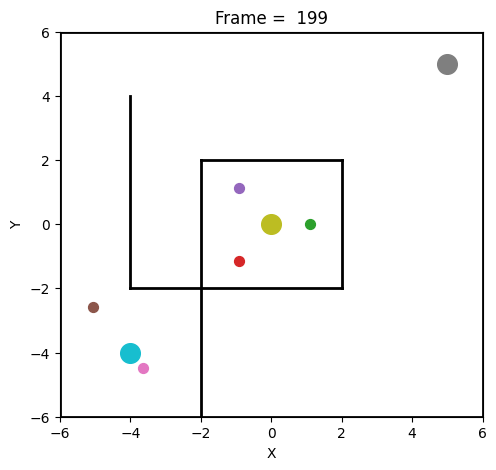

In [73]:
HTML(create_animation(floor_plan).to_html5_video())

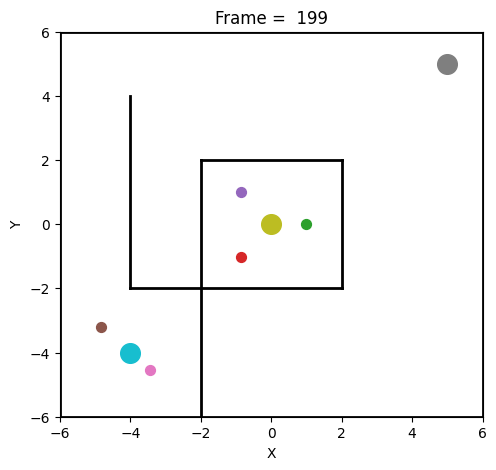

In [74]:
anisotropic = False
HTML(create_animation(floor_plan).to_html5_video())